# Preprocessing the EURO-CORDEX ensemble

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from cordex import preprocessing as cxpr

In [3]:
import intake
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm

In [4]:
from dask.distributed import Client, progress

client = Client()
client

Client Scheduler: tcp://127.0.0.1:44289 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 31.25 GiB


In [5]:
xr.__version__

'0.20.1'

## Data access

Open the catalog at DKRZ:

In [6]:
url = "/work/kd0956/Catalogs/mistral-cordex.json"
cat = intake.open_esm_datastore(url)
cat

,unique
product_id,3
CORDEX_domain,34
institute_id,95
driving_model_id,18
experiment_id,5
member,6
model_id,65
rcm_version_id,34
frequency,7
variable_id,105


Define attributes for the ensemble

In [7]:
scens = ["rcp26", "rcp45", "rcp85"]
expts = ["historical"] + scens
attrs = {
    "variable_id": ["tas"],
    "frequency": "mon",
    "CORDEX_domain": "EUR-11",
    "experiment_id": expts,
    "rcm_version_id": "v1",
}

In [27]:
import pandas as pd

pd.set_option("display.max_rows", None)
selection = cat.search(**attrs)
selection.df.groupby(
    [
        "model_id",
        "institute_id",
        "experiment_id",
        "driving_model_id",
        "member",
        "frequency",
        "rcm_version_id",
        "version",
    ]
)["variable_id"].unique().apply(list).to_frame()

variable_id
model_id                     institute_id experiment_id driving_model_id      member  frequency rcm_version_id version              
CLMcom-BTU-CCLM4-8-17        CLMcom-BTU   rcp26         MPI-M-MPI-ESM-LR      r1i1p1  mon       v1             v20171121       [tas]
CLMcom-CCLM4-8-17            CLMcom       historical    CCCma-CanESM2         r1i1p1  mon       v1             v20171121       [tas]
                                                        CNRM-CERFACS-CNRM-CM5 r1i1p1  mon       v1             v20140515       [tas]
                                                        ICHEC-EC-EARTH        r12i1p1 mon       v1             v20140515       [tas]
                                                        MIROC-MIROC5          r1i1p1  mon       v1             v20171121       [tas]
                                                        MOHC-HadGEM2-ES       r1i1p1  mon       v1             v20150320       [tas]
                                                        MPI-M-MPI-ESM-LR      r1i1p1  mon       v1             v20140515       [tas]
                                          rcp26         ICHEC-EC-EARTH        r12i1p1 mon       v1             v20170523       [tas]
                                                        MIROC-MIROC5          r1i1p1  mon       v1             v20180707       [tas]
                                          rcp45         CNRM-CERFACS-CNRM-CM5 r1i1p1  mon       v1             v20140515       [tas]
                                                        ICHEC-EC-EARTH        r12i1p1 mon       v1             v20140515       [tas]
                                                        MOHC-HadGEM2-ES       r1i1p1  mon       v1             v20150320       [tas]
                                                        MPI-M-MPI-ESM-LR      r1i1p1  mon       v1             v20140515       [tas]
                                          rcp85         CCCma-CanESM2         r1i1p1  mon       v1             v20171121       [tas]
                                                        CNRM-CERFACS-CNRM-CM5 r1i1p1  mon       v1             v20140515       [tas]
                                                        ICHEC-EC-EARTH        r12i1p1 mon       v1             v20140515       [tas]
                                                        MIROC-MIROC5          r1i1p1  mon       v1             v20171121       [tas]
                                                        MOHC-HadGEM2-ES       r1i1p1  mon       v1             v20150320       [tas]
                                                        MPI-M-MPI-ESM-LR      r1i1p1  mon       v1             v20140515       [tas]
CLMcom-ETH-COSMO-crCLIM-v1-1 CLMcom-ETH   historical    CNRM-CERFACS-CNRM-CM5 r1i1p1  mon       v1             v20210308       [tas]
                                                        ICHEC-EC-EARTH        r12i1p1 mon       v1             v20191210       [tas]
                                                                              r1i1p1  mon       v1             v20201215       [tas]
                                                                              r3i1p1  mon       v1             v20201209       [tas]
                                                        MOHC-HadGEM2-ES       r1i1p1  mon       v1             v20200609       [tas]
                                                        MPI-M-MPI-ESM-LR      r1i1p1  mon       v1             v20191219       [tas]
                                                                              r2i1p1  mon       v1             v20200211       [tas]
                                                                              r3i1p1  mon       v1             v20200424       [tas]
                                                        NCC-NorESM1-M         r1i1p1  mon       v1             v20191210       [tas]
                                          rcp85         CNRM-CERFACS-CNRM-CM5 r1i1p1  mon       v1             v20210430       [tas

That's quite some data. Let's load that data into a dictionary of datasets.

In [9]:
ds_dict = selection.to_dataset_dict(
    cdf_kwargs={"use_cftime": True, "chunks": {}}, preprocess=cxpr.rename_cordex
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency'


In [28]:
list(ds_dict.keys())[10:20]

['EUR-11.CNRM-CERFACS-CNRM-CM5.CLMcom-ETH.CLMcom-ETH-COSMO-crCLIM-v1-1.rcp85.mon',
 'EUR-11.MPI-M-MPI-ESM-LR.ICTP.ICTP-RegCM4-6.rcp85.mon',
 'EUR-11.NCC-NorESM1-M.MOHC.MOHC-HadREM3-GA7-05.rcp85.mon',
 'EUR-11.NCC-NorESM1-M.CNRM.CNRM-ALADIN63.rcp85.mon',
 'EUR-11.CNRM-CERFACS-CNRM-CM5.RMIB-UGent.RMIB-UGent-ALARO-0.historical.mon',
 'EUR-11.MPI-M-MPI-ESM-LR.SMHI.SMHI-RCA4.rcp45.mon',
 'EUR-11.IPSL-IPSL-CM5A-MR.DMI.DMI-HIRHAM5.rcp85.mon',
 'EUR-11.MOHC-HadGEM2-ES.MOHC.MOHC-HadREM3-GA7-05.historical.mon',
 'EUR-11.MOHC-HadGEM2-ES.MOHC.MOHC-HadREM3-GA7-05.rcp26.mon',
 'EUR-11.ICHEC-EC-EARTH.ICTP.ICTP-RegCM4-6.rcp85.mon']

In [33]:
ds_dict = cxpr.fix_known_issues(ds_dict)

In [36]:
for ds_id, ds in ds_dict.items():
    if ds.member.size > 1:
        print(ds_id, ds.member.size)

EUR-11.ICHEC-EC-EARTH.DMI.DMI-HIRHAM5.historical.mon 3
EUR-11.MPI-M-MPI-ESM-LR.SMHI.SMHI-RCA4.historical.mon 3
EUR-11.ICHEC-EC-EARTH.SMHI.SMHI-RCA4.historical.mon 3
EUR-11.MPI-M-MPI-ESM-LR.MPI-CSC.MPI-CSC-REMO2009.historical.mon 2
EUR-11.MPI-M-MPI-ESM-LR.SMHI.SMHI-RCA4.rcp85.mon 3
EUR-11.ICHEC-EC-EARTH.KNMI.KNMI-RACMO22E.rcp45.mon 2
EUR-11.ICHEC-EC-EARTH.GERICS.GERICS-REMO2015.rcp45.mon 2
EUR-11.MPI-M-MPI-ESM-LR.MPI-CSC.MPI-CSC-REMO2009.rcp26.mon 2
EUR-11.MPI-M-MPI-ESM-LR.MPI-CSC.MPI-CSC-REMO2009.rcp85.mon 2
EUR-11.ICHEC-EC-EARTH.SMHI.SMHI-RCA4.rcp85.mon 3
EUR-11.ICHEC-EC-EARTH.CLMcom-ETH.CLMcom-ETH-COSMO-crCLIM-v1-1.historical.mon 3
EUR-11.MPI-M-MPI-ESM-LR.MPI-CSC.MPI-CSC-REMO2009.rcp45.mon 2
EUR-11.ICHEC-EC-EARTH.DMI.DMI-HIRHAM5.rcp85.mon 3
EUR-11.MPI-M-MPI-ESM-LR.CLMcom-ETH.CLMcom-ETH-COSMO-crCLIM-v1-1.historical.mon 3
EUR-11.ICHEC-EC-EARTH.KNMI.KNMI-RACMO22E.historical.mon 3
EUR-11.ICHEC-EC-EARTH.KNMI.KNMI-RACMO22E.rcp85.mon 3
EUR-11.MPI-M-MPI-ESM-LR.CLMcom-ETH.CLMcom-ETH-COSMO-crC

We can see that there are quite some datasets that have more than one realization. But most CORDEX models only have on realization published, usually it's `r1i1p1`, the same as the driving model member id from which the member id is inherited during the downscaling. We will flatten that dimension, so that if there are more than 1 realizations, we will get one dataset per realization. That way, all datasets will have the same dimensions and are easier to compare.

In [34]:
ds_dict_flatten = cxpr.member_id_to_dset_id(ds_dict)
list(ds_dict_flatten.keys())[10:20]

['EUR-11.CNRM-CERFACS-CNRM-CM5.CLMcom-ETH.CLMcom-ETH-COSMO-crCLIM-v1-1.rcp85.mon.r1i1p1',
 'EUR-11.MPI-M-MPI-ESM-LR.ICTP.ICTP-RegCM4-6.rcp85.mon.r1i1p1',
 'EUR-11.NCC-NorESM1-M.MOHC.MOHC-HadREM3-GA7-05.rcp85.mon.r1i1p1',
 'EUR-11.NCC-NorESM1-M.CNRM.CNRM-ALADIN63.rcp85.mon.r1i1p1',
 'EUR-11.CNRM-CERFACS-CNRM-CM5.RMIB-UGent.RMIB-UGent-ALARO-0.historical.mon.r1i1p1',
 'EUR-11.MPI-M-MPI-ESM-LR.SMHI.SMHI-RCA4.rcp45.mon.r1i1p1',
 'EUR-11.IPSL-IPSL-CM5A-MR.DMI.DMI-HIRHAM5.rcp85.mon.r1i1p1',
 'EUR-11.MOHC-HadGEM2-ES.MOHC.MOHC-HadREM3-GA7-05.historical.mon.r1i1p1',
 'EUR-11.MOHC-HadGEM2-ES.MOHC.MOHC-HadREM3-GA7-05.rcp26.mon.r1i1p1',
 'EUR-11.ICHEC-EC-EARTH.ICTP.ICTP-RegCM4-6.rcp85.mon.r12i1p1']

You can see, that the member id is now part of the dataset id in the dictionary in order to distinguish datasets of different realizations. This is also a little bit more in line with how CMIP6 datasets are handled.

In [35]:
experiments = cxpr.sort_ds_dict_by_attr(ds_dict_flatten, "model_id")
experiments.keys()

dict_keys(['ICTP-RegCM4-6', 'CNRM-ALADIN63', 'KNMI-RACMO22E', 'RMIB-UGent-ALARO-0', 'GERICS-REMO2015', 'MOHC-HadREM3-GA7-05', 'CLMcom-ETH-COSMO-crCLIM-v1-1', 'SMHI-RCA4', 'DMI-HIRHAM5', 'CLMcom-CCLM4-8-17', 'IPSL-INERIS-WRF331F', 'UHOH-WRF361H', 'ALADIN53', 'MPI-CSC-REMO2009', 'CLMcom-BTU-CCLM4-8-17'])

In [38]:
for ds_it, ds in experiments["ALADIN53"].items():
    print(ds_it)
    print(ds.tas.units, ds.tas.min().values, ds.tas.max().values)

EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.historical.mon.r1i1p1
K
K 216.54031 315.3461
EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.rcp26.mon.r1i1p1
K
K 218.8659 316.74243
EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.rcp45.mon.r1i1p1
K
K 217.19263 318.19208
EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.rcp85.mon.r1i1p1
K
K 220.42935 320.67554


In [39]:
for ds_id, ds in ds_dict_flatten.items():
    grid_mapping = cxpr.get_grid_mapping_name(ds)
    if grid_mapping != "rotated_latitude_longitude":
        print(ds_id, grid_mapping)
        ds_dict_flatten[ds_id] = cxpr.remap_lambert_conformal(ds)

EUR-11.MPI-M-MPI-ESM-LR.ICTP.ICTP-RegCM4-6.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MOHC-HadGEM2-ES.CNRM.CNRM-ALADIN63.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.NCC-NorESM1-M.ICTP.ICTP-RegCM4-6.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.NCC-NorESM1-M.ICTP.ICTP-RegCM4-6.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.RMIB-UGent.RMIB-UGent-ALARO-0.rcp45.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.RMIB-UGent.RMIB-UGent-ALARO-0.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MPI-M-MPI-ESM-LR.ICTP.ICTP-RegCM4-6.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.NCC-NorESM1-M.CNRM.CNRM-ALADIN63.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.RMIB-UGent.RMIB-UGent-ALARO-0.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.ICHEC-EC-EARTH.ICTP.ICTP-RegCM4-6.rcp85.mon.r12i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MOHC-HadGEM2-ES.ICTP.ICTP-RegCM4-6.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MPI-M-MPI-ESM-LR.CNRM.CNRM-ALADIN63.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MPI-M-MPI-ESM-LR.ICTP.ICTP-RegCM4-6.rcp26.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.rcp26.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MOHC-HadGEM2-ES.CNRM.CNRM-ALADIN63.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.NCC-NorESM1-M.CNRM.CNRM-ALADIN63.historical.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MOHC-HadGEM2-ES.ICTP.ICTP-RegCM4-6.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MPI-M-MPI-ESM-LR.CNRM.CNRM-ALADIN63.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.rcp45.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.RMIB-UGent.RMIB-UGent-ALARO-0.rcp26.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.CNRM-CERFACS-CNRM-CM5.CNRM.ALADIN53.rcp85.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.MOHC-HadGEM2-ES.ICTP.ICTP-RegCM4-6.rcp26.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.NCC-NorESM1-M.ICTP.ICTP-RegCM4-6.rcp26.mon.r1i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


EUR-11.ICHEC-EC-EARTH.ICTP.ICTP-RegCM4-6.historical.mon.r12i1p1 lambert_conformal_conic


/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [40]:
for ds_id, ds in ds_dict_flatten.items():
    grid_mapping = cxpr.get_grid_mapping_name(ds)
    if grid_mapping != "rotated_latitude_longitude":
        print(ds_id, grid_mapping)

In [41]:
cxpr.get_grid_mapping_name(
    ds_dict_flatten["EUR-11.MOHC-HadGEM2-ES.CNRM.CNRM-ALADIN63.historical.mon.r1i1p1"]
)

'rotated_latitude_longitude'

In [42]:
dsets_rotated = {}

for ds_id, ds in ds_dict_flatten.items():
    grid_mapping = cxpr.get_grid_mapping_name(ds)
    if grid_mapping == "rotated_latitude_longitude":
        dsets_rotated[ds_id] = ds

In [43]:
experiments = cxpr.sort_ds_dict_by_attr(dsets_rotated, "experiment_id")
experiments.keys()

dict_keys(['historical', 'rcp85', 'rcp45', 'rcp26'])

In [56]:
len(experiments["rcp85"].keys())

65

In [44]:
import dask
from xclim import ensembles

dask.config.set(**{"array.slicing.split_large_chunks": True})


def create_ensemble(ds_dict, resample_freq=None):
    ds_list = []
    drops = ["bnds", "bounds", "vertices", "height"]
    for ds in ds_dict.values():
        ds = cxpr.replace_coords(ds)
        for var in ds.data_vars:
            if any([drop in var for drop in drops]):
                ds = ds.drop(var)
            else:
                ds[var] = ds[var].squeeze(drop=True)
        # ds = cxpr.replace_lon_lat(ds)
        ds_list.append(ds)
    ensemble = ensembles.create_ensemble(ds_list, resample_freq=resample_freq)
    ensemble["realization"] = list(ds_dict.keys())
    return ensemble

In [57]:
ensemble_rcp85 = create_ensemble(experiments["rcp85"], resample_freq="MS")

In [58]:
ensemble = ensemble_rcp85

In [59]:
ensemble.time.min().values, ensemble.time.max().values

(numpy.datetime64('2005-12-01T00:00:00.000000000'),
 numpy.datetime64('2100-12-01T00:00:00.000000000'))

In [ ]:
ensemble

In [64]:
ensemble.tas.min().values

array(0.)

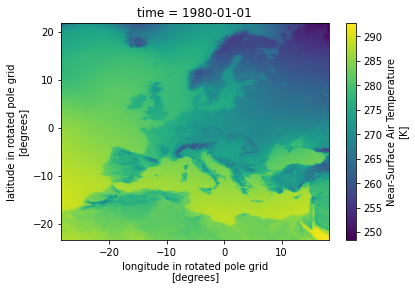

In [69]:
mean = ensemble.sel(time="1980-01").tas.mean(dim="realization")